In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
% matplotlib inline

/Users/alex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Smoter
def Smoter(X, y, is_random=False):
    if is_random == True:
        random_lst = list(np.random.randint(0, 1000, 4))
    elif is_random == False:
        random_lst = [0] * 4

    sm = SMOTE(random_state=random_lst[2])
    X_smote, y_smote = sm.fit_sample(X, y)
    y_smote = y_smote[:,np.newaxis]
    return X_smote, y_smote

In [3]:
def evaluate(v_xs, v_ys, sess):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob:1})
    
    predicted = np.argmax(y_pre, 1)
    actual = np.argmax(v_ys, 1)
    
#     print("predicted", predicted)
#     print("actual", actual)
    
    # Count true positives, true negatives, false positives and false negatives.
    tp = np.count_nonzero(predicted * actual)
    tn = np.count_nonzero((predicted - 1) * (actual - 1))
    fp = np.count_nonzero(predicted * (actual - 1))
    fn = np.count_nonzero((predicted - 1) * actual)

#     print('TP=',tp,'FP=',fp,'TN=',tn,'FN=',fn)
    # Calculate accuracy, precision, recall and F1 score.
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
#     print('Precision = ', precision)
#     print('Recall = ', recall)
#     print('F1 Score = ', f1_score)
#     print('Accuracy = ', accuracy)
    return precision, recall, f1_score, accuracy

bootstrap

return: samples:[num_samples,n_samples,n_features]

In [ ]:
def bootstrap(data, num_samples):
    n = len(data)
    idx = np.random.randint(0, n, size=(num_samples, n))
    samples = data[idx]
    return samples

In [4]:
def weight_variable(shape,name=None):
    initial = tf.truncated_normal(shape, stddev=0.1)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.Variable(initial,name=name)


def bias_variable(shape,name):
    initial = tf.constant(0.1, shape=shape)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.Variable(initial,name=name)

hyperparameters

In [5]:
valid_size = 0.33
random_seed = 42
max_iterations = 1000
kp = 1
lr = 0.01

load data

In [6]:
train = pd.read_csv("../data/water/csv/train2017.csv")
test = pd.read_csv("../data/water/csv/test2017.csv")

In [7]:
X_train = train.values[:, 0:-1]
y_train = train.values[:, -1]
X_test = test.values[:, 0:-1]
y_test = train.values[:, -1]

train valid split

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = valid_size, 
                                                      stratify = y_train, random_state = random_seed)

In [9]:
print("1 in train:", sum(y_train == 1) / len(y_train))
print("1 in valid", sum(y_valid == 1) / len(y_valid))

1 in train: 0.0157049727924142
1 in valid 0.01569678407350689


oversampling

In [10]:
X_train_oversampled, y_train_oversampled = Smoter(X_train, y_train, is_random=True)

print("============ SMOTE ============")
print("train: %d, contains %.4f of 0 , after SMOTE: train: %d contains %.4f of 1" 
      %(X_train.shape[0], 
        (y_train == 0).sum()/y_train.shape[0], 
        X_train_oversampled.shape[0], 
        (y_train_oversampled == 0).sum()/y_train_oversampled.shape[0]))

============ SMOTE ============
train: 74244, contains 0.9843 of 0 , after SMOTE: train: 146156 contains 0.5000 of 1


normalize

In [11]:
clean_pipeline = Pipeline([('imputer', preprocessing.Imputer(missing_values='NaN',strategy="median")),
                           ('std_scaler', preprocessing.StandardScaler()),])
X_train_oversampled = clean_pipeline.fit_transform(X_train_oversampled)
X_valid = clean_pipeline.fit_transform(X_valid)
X_test = clean_pipeline.fit_transform(X_test)

transfer y into probability vector

In [12]:
y_train_oversampled_pro = np.zeros([y_train_oversampled.shape[0], 2])
for i in range(len(y_train_oversampled)):
    if y_train_oversampled[i] == 1:
        y_train_oversampled_pro[i] = np.array([0, 1])
    else:
        y_train_oversampled_pro[i] = np.array([1, 0])
y_train_oversampled = y_train_oversampled_pro

y_valid_pro = np.zeros([y_valid.shape[0], 2])
for i in range(len(y_valid)):
    if y_valid[i] == 1:
        y_valid_pro[i] = np.array([0, 1])
    else:
        y_valid_pro[i] = np.array([1, 0])
y_valid = y_valid_pro


y_test_pro = np.zeros([y_test.shape[0], 2])
for i in range(len(y_test)):
    if y_test[i] == 1:
        y_test_pro[i] = np.array([0, 1])
    else:
        y_test_pro[i] = np.array([1, 0])
y_test = y_test_pro


# y_valid_nonezero = np.count_nonzero(np.argmax(y_valid, 1))
# print("y_valid: 1 contains: ", y_valid_nonezero, "/",len(y_valid))

In [13]:
keep_prob = tf.placeholder(tf.float32)
xs = tf.placeholder(tf.float32, [None, 9])
ys = tf.placeholder(tf.float32, [None, 2])
learning_rate = tf.placeholder(tf.float32)
X_input = tf.reshape(xs,[-1,9,1]) # [n_samples, 9 ,1]    -1 具体是多少由导入数据决定（多少组数据） 

In [14]:
def MLP():
    ## func1 layer ##
    W_fc1 = weight_variable([9,2],name="W_fc1")
    b_fc1 = bias_variable([2],name="b_fc1")

    X_input_flat = tf.reshape(X_input, [-1,9])
    h_fc1 = tf.nn.softmax(tf.matmul(X_input_flat, W_fc1)+b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    prediction = h_fc1_drop

    var_dict = {'W_fc1': W_fc1, 
                'b_fc1': b_fc1}
    return prediction, var_dict

In [15]:
# output
prediction, var_dict = MLP()

# the error between prediction and real data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=ys))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [16]:
valid_acc = []
valid_f1 = []
valid_loss = []

train_acc = []
train_f1 = []
train_loss = []

X_train_oversampled = np.array(X_train_oversampled, dtype=np.float32)
y_train_oversampled = np.array(y_train_oversampled, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)

saver = tf.train.Saver(var_dict)

train

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
            
    true_iteration = 1
    for i in range(max_iterations):
        feed = {xs : X_train_oversampled, ys : y_train_oversampled, keep_prob : kp, learning_rate : lr}
        
        # train
        # print("++++++++++++++++++ train ++++++++++++++++++")
        loss, _ = sess.run([cost, train_op],feed_dict=feed)
        precision, recall, f1_score, accuracy = evaluate(X_train_oversampled, y_train_oversampled, sess)
        
        train_loss.append(loss)
        train_f1.append(f1_score)
        train_acc.append(accuracy)
        
        # valid cost
        loss_v = sess.run(cost, feed_dict={xs: X_valid, ys: y_valid, keep_prob: 1})
        valid_loss.append(loss_v)
        # valid evaluationX_testX_testX_testX_test
        # print("++++++++++++++++++ valid ++++++++++++++++++")
        valid_precision, valid_recall, valid_f1_score, valid_accuracy = evaluate(X_valid, y_valid, sess)
        valid_f1.append(valid_f1_score)
        valid_acc.append(valid_accuracy)

        if valid_f1_score >= 0.98:
            break
        print("Iteration: {}/{}\n".format(true_iteration, max_iterations),
              "Train loss: {:6f}".format(loss),
              "Train acc: {:.6f}".format(accuracy),
              "Train f1: {:.6f}\n".format(f1_score),
              "Valid loss: {:6f}".format(loss_v),
              "Valid acc: {:.6f}".format(valid_accuracy),
              "Valid f1: {:.6f}".format(valid_f1_score))
        true_iteration += 1
            
#     save_path = saver.save(sess,"mlp_2017/2017_save_net.ckpt")
#     print("Save to path:", save_path)


Iteration: 1/1000
 Train loss: 0.682833 Train acc: 0.641157 Train f1: 0.596167
 Valid loss: 0.688482 Valid acc: 0.527592 Valid f1: 0.037658
Iteration: 2/1000
 Train loss: 0.678377 Train acc: 0.673931 Train f1: 0.614852
 Valid loss: 0.683134 Valid acc: 0.559150 Valid f1: 0.040131
Iteration: 3/1000
 Train loss: 0.674370 Train acc: 0.692007 Train f1: 0.611628
 Valid loss: 0.678073 Valid acc: 0.578210 Valid f1: 0.041988
Iteration: 4/1000
 Train loss: 0.670803 Train acc: 0.677639 Train f1: 0.554025
 Valid loss: 0.673361 Valid acc: 0.588876 Valid f1: 0.043030
Iteration: 5/1000
 Train loss: 0.667645 Train acc: 0.684837 Train f1: 0.555707
 Valid loss: 0.669068 Valid acc: 0.598748 Valid f1: 0.044167
Iteration: 6/1000
 Train loss: 0.664844 Train acc: 0.683359 Train f1: 0.551868
 Valid loss: 0.665267 Valid acc: 0.607635 Valid f1: 0.044740
Iteration: 7/1000
 Train loss: 0.662361 Train acc: 0.679582 Train f1: 0.547058
 Valid loss: 0.662048 Valid acc: 0.618081 Valid f1: 0.046559
Iteration: 8/1000
 T

Iteration: 60/1000
 Train loss: 0.624764 Train acc: 0.718862 Train f1: 0.634730
 Valid loss: 0.647506 Valid acc: 0.603424 Valid f1: 0.050668
Iteration: 61/1000
 Train loss: 0.624272 Train acc: 0.718869 Train f1: 0.634969
 Valid loss: 0.647117 Valid acc: 0.604408 Valid f1: 0.050663
Iteration: 62/1000
 Train loss: 0.623784 Train acc: 0.718862 Train f1: 0.635151
 Valid loss: 0.646786 Valid acc: 0.605338 Valid f1: 0.050651
Iteration: 63/1000
 Train loss: 0.623297 Train acc: 0.719006 Train f1: 0.635645
 Valid loss: 0.646501 Valid acc: 0.606377 Valid f1: 0.050778
Iteration: 64/1000
 Train loss: 0.622813 Train acc: 0.719143 Train f1: 0.636094
 Valid loss: 0.646255 Valid acc: 0.607170 Valid f1: 0.050875
Iteration: 65/1000
 Train loss: 0.622332 Train acc: 0.719382 Train f1: 0.636729
 Valid loss: 0.646035 Valid acc: 0.607635 Valid f1: 0.050933
Iteration: 66/1000
 Train loss: 0.621855 Train acc: 0.719300 Train f1: 0.636887
 Valid loss: 0.645833 Valid acc: 0.608237 Valid f1: 0.051007
Iteration: 67

Iteration: 120/1000
 Train loss: 0.603619 Train acc: 0.726765 Train f1: 0.652016
 Valid loss: 0.661012 Valid acc: 0.600142 Valid f1: 0.050519
Iteration: 121/1000
 Train loss: 0.603375 Train acc: 0.726983 Train f1: 0.652343
 Valid loss: 0.661651 Valid acc: 0.599568 Valid f1: 0.050574
Iteration: 122/1000
 Train loss: 0.603132 Train acc: 0.727264 Train f1: 0.652752
 Valid loss: 0.662296 Valid acc: 0.598912 Valid f1: 0.050618
Iteration: 123/1000
 Train loss: 0.602891 Train acc: 0.727613 Train f1: 0.653266
 Valid loss: 0.662944 Valid acc: 0.598474 Valid f1: 0.050689
Iteration: 124/1000
 Train loss: 0.602653 Train acc: 0.727805 Train f1: 0.653546
 Valid loss: 0.663597 Valid acc: 0.597872 Valid f1: 0.050617
Iteration: 125/1000
 Train loss: 0.602416 Train acc: 0.728065 Train f1: 0.653931
 Valid loss: 0.664252 Valid acc: 0.597271 Valid f1: 0.050545
Iteration: 126/1000
 Train loss: 0.602181 Train acc: 0.728277 Train f1: 0.654276
 Valid loss: 0.664908 Valid acc: 0.596314 Valid f1: 0.050431
Iterat

Iteration: 180/1000
 Train loss: 0.591466 Train acc: 0.737616 Train f1: 0.668276
 Valid loss: 0.698418 Valid acc: 0.561639 Valid f1: 0.047308
Iteration: 181/1000
 Train loss: 0.591296 Train acc: 0.737725 Train f1: 0.668448
 Valid loss: 0.698976 Valid acc: 0.560928 Valid f1: 0.047235
Iteration: 182/1000
 Train loss: 0.591126 Train acc: 0.737883 Train f1: 0.668679
 Valid loss: 0.699530 Valid acc: 0.560517 Valid f1: 0.047193
Iteration: 183/1000
 Train loss: 0.590957 Train acc: 0.738061 Train f1: 0.668932
 Valid loss: 0.700084 Valid acc: 0.559724 Valid f1: 0.047112
Iteration: 184/1000
 Train loss: 0.590789 Train acc: 0.738245 Train f1: 0.669214
 Valid loss: 0.700634 Valid acc: 0.559068 Valid f1: 0.047045
Iteration: 185/1000
 Train loss: 0.590622 Train acc: 0.738430 Train f1: 0.669531
 Valid loss: 0.701182 Valid acc: 0.558466 Valid f1: 0.046984
Iteration: 186/1000
 Train loss: 0.590456 Train acc: 0.738622 Train f1: 0.669813
 Valid loss: 0.701729 Valid acc: 0.558002 Valid f1: 0.047049
Iterat

Iteration: 240/1000
 Train loss: 0.582414 Train acc: 0.746237 Train f1: 0.681877
 Valid loss: 0.727353 Valid acc: 0.535277 Valid f1: 0.045066
Iteration: 241/1000
 Train loss: 0.582279 Train acc: 0.746333 Train f1: 0.682035
 Valid loss: 0.727748 Valid acc: 0.535003 Valid f1: 0.045041
Iteration: 242/1000
 Train loss: 0.582146 Train acc: 0.746538 Train f1: 0.682336
 Valid loss: 0.728139 Valid acc: 0.534675 Valid f1: 0.045011
Iteration: 243/1000
 Train loss: 0.582013 Train acc: 0.746675 Train f1: 0.682568
 Valid loss: 0.728527 Valid acc: 0.534292 Valid f1: 0.044975
Iteration: 244/1000
 Train loss: 0.581880 Train acc: 0.746750 Train f1: 0.682692
 Valid loss: 0.728911 Valid acc: 0.533991 Valid f1: 0.044948
Iteration: 245/1000
 Train loss: 0.581749 Train acc: 0.746921 Train f1: 0.682947
 Valid loss: 0.729292 Valid acc: 0.533499 Valid f1: 0.044902
Iteration: 246/1000
 Train loss: 0.581616 Train acc: 0.747072 Train f1: 0.683173
 Valid loss: 0.729671 Valid acc: 0.533253 Valid f1: 0.044987
Iterat

Iteration: 300/1000
 Train loss: 0.575130 Train acc: 0.753770 Train f1: 0.693625
 Valid loss: 0.745764 Valid acc: 0.522397 Valid f1: 0.043800
Iteration: 301/1000
 Train loss: 0.575020 Train acc: 0.753907 Train f1: 0.693827
 Valid loss: 0.745994 Valid acc: 0.522342 Valid f1: 0.043795
Iteration: 302/1000
 Train loss: 0.574911 Train acc: 0.754023 Train f1: 0.693985
 Valid loss: 0.746223 Valid acc: 0.522260 Valid f1: 0.043788
Iteration: 303/1000
 Train loss: 0.574803 Train acc: 0.754098 Train f1: 0.694091
 Valid loss: 0.746450 Valid acc: 0.522068 Valid f1: 0.043771
Iteration: 304/1000
 Train loss: 0.574694 Train acc: 0.754201 Train f1: 0.694237
 Valid loss: 0.746674 Valid acc: 0.522014 Valid f1: 0.043766
Iteration: 305/1000
 Train loss: 0.574586 Train acc: 0.754290 Train f1: 0.694366
 Valid loss: 0.746897 Valid acc: 0.521932 Valid f1: 0.043759
Iteration: 306/1000
 Train loss: 0.574478 Train acc: 0.754331 Train f1: 0.694422
 Valid loss: 0.747118 Valid acc: 0.521631 Valid f1: 0.043733
Iterat

Iteration: 361/1000
 Train loss: 0.569078 Train acc: 0.758518 Train f1: 0.700802
 Valid loss: 0.757261 Valid acc: 0.516353 Valid f1: 0.042862
Iteration: 362/1000
 Train loss: 0.568988 Train acc: 0.758641 Train f1: 0.700995
 Valid loss: 0.757423 Valid acc: 0.516326 Valid f1: 0.042859
Iteration: 363/1000
 Train loss: 0.568898 Train acc: 0.758765 Train f1: 0.701183
 Valid loss: 0.757583 Valid acc: 0.516189 Valid f1: 0.042848
Iteration: 364/1000
 Train loss: 0.568810 Train acc: 0.758833 Train f1: 0.701288
 Valid loss: 0.757743 Valid acc: 0.516107 Valid f1: 0.042841
Iteration: 365/1000
 Train loss: 0.568722 Train acc: 0.758977 Train f1: 0.701489
 Valid loss: 0.757903 Valid acc: 0.515916 Valid f1: 0.042825
Iteration: 366/1000
 Train loss: 0.568635 Train acc: 0.759052 Train f1: 0.701625
 Valid loss: 0.758063 Valid acc: 0.515751 Valid f1: 0.042811
Iteration: 367/1000
 Train loss: 0.568547 Train acc: 0.759196 Train f1: 0.701826
 Valid loss: 0.758221 Valid acc: 0.515615 Valid f1: 0.042799
Iterat

Iteration: 420/1000
 Train loss: 0.564275 Train acc: 0.763219 Train f1: 0.708300
 Valid loss: 0.765867 Valid acc: 0.511431 Valid f1: 0.041729
Iteration: 421/1000
 Train loss: 0.564201 Train acc: 0.763239 Train f1: 0.708347
 Valid loss: 0.765999 Valid acc: 0.511349 Valid f1: 0.041723
Iteration: 422/1000
 Train loss: 0.564127 Train acc: 0.763342 Train f1: 0.708501
 Valid loss: 0.766129 Valid acc: 0.511294 Valid f1: 0.041718
Iteration: 423/1000
 Train loss: 0.564053 Train acc: 0.763383 Train f1: 0.708576
 Valid loss: 0.766259 Valid acc: 0.511267 Valid f1: 0.041716
Iteration: 424/1000
 Train loss: 0.563980 Train acc: 0.763417 Train f1: 0.708635
 Valid loss: 0.766389 Valid acc: 0.511130 Valid f1: 0.041705
Iteration: 425/1000
 Train loss: 0.563906 Train acc: 0.763506 Train f1: 0.708787
 Valid loss: 0.766519 Valid acc: 0.511130 Valid f1: 0.041705
Iteration: 426/1000
 Train loss: 0.563832 Train acc: 0.763554 Train f1: 0.708858
 Valid loss: 0.766649 Valid acc: 0.511021 Valid f1: 0.041696
Iterat

Iteration: 480/1000
 Train loss: 0.560182 Train acc: 0.767262 Train f1: 0.714645
 Valid loss: 0.773011 Valid acc: 0.507055 Valid f1: 0.041578
Iteration: 481/1000
 Train loss: 0.560119 Train acc: 0.767276 Train f1: 0.714700
 Valid loss: 0.773117 Valid acc: 0.506946 Valid f1: 0.041569
Iteration: 482/1000
 Train loss: 0.560056 Train acc: 0.767379 Train f1: 0.714848
 Valid loss: 0.773223 Valid acc: 0.506891 Valid f1: 0.041565
Iteration: 483/1000
 Train loss: 0.559994 Train acc: 0.767440 Train f1: 0.714945
 Valid loss: 0.773328 Valid acc: 0.506837 Valid f1: 0.041560
Iteration: 484/1000
 Train loss: 0.559932 Train acc: 0.767516 Train f1: 0.715063
 Valid loss: 0.773433 Valid acc: 0.506727 Valid f1: 0.041552
Iteration: 485/1000
 Train loss: 0.559870 Train acc: 0.767543 Train f1: 0.715111
 Valid loss: 0.773537 Valid acc: 0.506700 Valid f1: 0.041651
Iteration: 486/1000
 Train loss: 0.559808 Train acc: 0.767618 Train f1: 0.715230
 Valid loss: 0.773641 Valid acc: 0.506590 Valid f1: 0.041642
Iterat

Iteration: 540/1000
 Train loss: 0.556692 Train acc: 0.770266 Train f1: 0.719563
 Valid loss: 0.778596 Valid acc: 0.504075 Valid f1: 0.041440
Iteration: 541/1000
 Train loss: 0.556638 Train acc: 0.770314 Train f1: 0.719647
 Valid loss: 0.778676 Valid acc: 0.504075 Valid f1: 0.041440
Iteration: 542/1000
 Train loss: 0.556584 Train acc: 0.770375 Train f1: 0.719729
 Valid loss: 0.778755 Valid acc: 0.504075 Valid f1: 0.041440
Iteration: 543/1000
 Train loss: 0.556531 Train acc: 0.770410 Train f1: 0.719788
 Valid loss: 0.778834 Valid acc: 0.503993 Valid f1: 0.041433
Iteration: 544/1000
 Train loss: 0.556478 Train acc: 0.770437 Train f1: 0.719826
 Valid loss: 0.778913 Valid acc: 0.503965 Valid f1: 0.041431
Iteration: 545/1000
 Train loss: 0.556424 Train acc: 0.770458 Train f1: 0.719862
 Valid loss: 0.778991 Valid acc: 0.503965 Valid f1: 0.041431
Iteration: 546/1000
 Train loss: 0.556371 Train acc: 0.770519 Train f1: 0.719954
 Valid loss: 0.779070 Valid acc: 0.503993 Valid f1: 0.041433
Iterat

Iteration: 599/1000
 Train loss: 0.553724 Train acc: 0.772852 Train f1: 0.723685
 Valid loss: 0.782676 Valid acc: 0.501641 Valid f1: 0.041246
Iteration: 600/1000
 Train loss: 0.553676 Train acc: 0.772880 Train f1: 0.723736
 Valid loss: 0.782735 Valid acc: 0.501531 Valid f1: 0.041237
Iteration: 601/1000
 Train loss: 0.553630 Train acc: 0.772948 Train f1: 0.723843
 Valid loss: 0.782793 Valid acc: 0.501449 Valid f1: 0.041231
Iteration: 602/1000
 Train loss: 0.553583 Train acc: 0.772962 Train f1: 0.723873
 Valid loss: 0.782851 Valid acc: 0.501449 Valid f1: 0.041231
Iteration: 603/1000
 Train loss: 0.553537 Train acc: 0.773003 Train f1: 0.723941
 Valid loss: 0.782909 Valid acc: 0.501367 Valid f1: 0.041224
Iteration: 604/1000
 Train loss: 0.553490 Train acc: 0.773017 Train f1: 0.723972
 Valid loss: 0.782967 Valid acc: 0.501477 Valid f1: 0.041233
Iteration: 605/1000
 Train loss: 0.553444 Train acc: 0.773044 Train f1: 0.724014
 Valid loss: 0.783025 Valid acc: 0.501504 Valid f1: 0.041235
Iterat

Iteration: 657/1000
 Train loss: 0.551169 Train acc: 0.774748 Train f1: 0.726847
 Valid loss: 0.785616 Valid acc: 0.500984 Valid f1: 0.041295
Iteration: 658/1000
 Train loss: 0.551128 Train acc: 0.774741 Train f1: 0.726855
 Valid loss: 0.785658 Valid acc: 0.500984 Valid f1: 0.041295
Iteration: 659/1000
 Train loss: 0.551087 Train acc: 0.774802 Train f1: 0.726950
 Valid loss: 0.785701 Valid acc: 0.500930 Valid f1: 0.041290
Iteration: 660/1000
 Train loss: 0.551045 Train acc: 0.774823 Train f1: 0.726986
 Valid loss: 0.785744 Valid acc: 0.500930 Valid f1: 0.041290
Iteration: 661/1000
 Train loss: 0.551005 Train acc: 0.774864 Train f1: 0.727063
 Valid loss: 0.785786 Valid acc: 0.500984 Valid f1: 0.041295
Iteration: 662/1000
 Train loss: 0.550964 Train acc: 0.774898 Train f1: 0.727111
 Valid loss: 0.785828 Valid acc: 0.500902 Valid f1: 0.041288
Iteration: 663/1000
 Train loss: 0.550923 Train acc: 0.774925 Train f1: 0.727158
 Valid loss: 0.785870 Valid acc: 0.500984 Valid f1: 0.041395
Iterat

Iteration: 717/1000
 Train loss: 0.548840 Train acc: 0.776609 Train f1: 0.730058
 Valid loss: 0.787820 Valid acc: 0.500356 Valid f1: 0.041446
Iteration: 718/1000
 Train loss: 0.548804 Train acc: 0.776650 Train f1: 0.730121
 Valid loss: 0.787850 Valid acc: 0.500383 Valid f1: 0.041448
Iteration: 719/1000
 Train loss: 0.548767 Train acc: 0.776684 Train f1: 0.730169
 Valid loss: 0.787881 Valid acc: 0.500328 Valid f1: 0.041444
Iteration: 720/1000
 Train loss: 0.548731 Train acc: 0.776725 Train f1: 0.730237
 Valid loss: 0.787912 Valid acc: 0.500301 Valid f1: 0.041442
Iteration: 721/1000
 Train loss: 0.548694 Train acc: 0.776718 Train f1: 0.730244
 Valid loss: 0.787942 Valid acc: 0.500383 Valid f1: 0.041448
Iteration: 722/1000
 Train loss: 0.548659 Train acc: 0.776725 Train f1: 0.730268
 Valid loss: 0.787972 Valid acc: 0.500383 Valid f1: 0.041448
Iteration: 723/1000
 Train loss: 0.548623 Train acc: 0.776766 Train f1: 0.730340
 Valid loss: 0.788002 Valid acc: 0.500328 Valid f1: 0.041444
Iterat

Iteration: 780/1000
 Train loss: 0.546680 Train acc: 0.778531 Train f1: 0.733235
 Valid loss: 0.789458 Valid acc: 0.500547 Valid f1: 0.041461
Iteration: 781/1000
 Train loss: 0.546647 Train acc: 0.778565 Train f1: 0.733283
 Valid loss: 0.789480 Valid acc: 0.500547 Valid f1: 0.041461
Iteration: 782/1000
 Train loss: 0.546615 Train acc: 0.778593 Train f1: 0.733320
 Valid loss: 0.789501 Valid acc: 0.500547 Valid f1: 0.041461
Iteration: 783/1000
 Train loss: 0.546583 Train acc: 0.778606 Train f1: 0.733354
 Valid loss: 0.789522 Valid acc: 0.500547 Valid f1: 0.041461
Iteration: 784/1000
 Train loss: 0.546551 Train acc: 0.778613 Train f1: 0.733378
 Valid loss: 0.789543 Valid acc: 0.500602 Valid f1: 0.041465
Iteration: 785/1000
 Train loss: 0.546520 Train acc: 0.778654 Train f1: 0.733436
 Valid loss: 0.789564 Valid acc: 0.500547 Valid f1: 0.041461
Iteration: 786/1000
 Train loss: 0.546488 Train acc: 0.778675 Train f1: 0.733467
 Valid loss: 0.789585 Valid acc: 0.500520 Valid f1: 0.041459
Iterat

Iteration: 839/1000
 Train loss: 0.544881 Train acc: 0.779982 Train f1: 0.735575
 Valid loss: 0.790532 Valid acc: 0.500273 Valid f1: 0.041540
Iteration: 840/1000
 Train loss: 0.544852 Train acc: 0.780016 Train f1: 0.735631
 Valid loss: 0.790547 Valid acc: 0.500383 Valid f1: 0.041549
Iteration: 841/1000
 Train loss: 0.544823 Train acc: 0.780009 Train f1: 0.735630
 Valid loss: 0.790562 Valid acc: 0.500410 Valid f1: 0.041551
Iteration: 842/1000
 Train loss: 0.544793 Train acc: 0.780009 Train f1: 0.735634
 Valid loss: 0.790577 Valid acc: 0.500438 Valid f1: 0.041553
Iteration: 843/1000
 Train loss: 0.544765 Train acc: 0.780064 Train f1: 0.735708
 Valid loss: 0.790591 Valid acc: 0.500410 Valid f1: 0.041551
Iteration: 844/1000
 Train loss: 0.544737 Train acc: 0.780057 Train f1: 0.735707
 Valid loss: 0.790606 Valid acc: 0.500438 Valid f1: 0.041553
Iteration: 845/1000
 Train loss: 0.544708 Train acc: 0.780071 Train f1: 0.735732
 Valid loss: 0.790621 Valid acc: 0.500438 Valid f1: 0.041553
Iterat

Iteration: 899/1000
 Train loss: 0.543238 Train acc: 0.781213 Train f1: 0.737569
 Valid loss: 0.791286 Valid acc: 0.500984 Valid f1: 0.041597
Iteration: 900/1000
 Train loss: 0.543212 Train acc: 0.781247 Train f1: 0.737620
 Valid loss: 0.791296 Valid acc: 0.501012 Valid f1: 0.041599
Iteration: 901/1000
 Train loss: 0.543186 Train acc: 0.781288 Train f1: 0.737674
 Valid loss: 0.791306 Valid acc: 0.501067 Valid f1: 0.041603
Iteration: 902/1000
 Train loss: 0.543161 Train acc: 0.781302 Train f1: 0.737690
 Valid loss: 0.791317 Valid acc: 0.501012 Valid f1: 0.041599
Iteration: 903/1000
 Train loss: 0.543135 Train acc: 0.781316 Train f1: 0.737715
 Valid loss: 0.791327 Valid acc: 0.501039 Valid f1: 0.041601
Iteration: 904/1000
 Train loss: 0.543109 Train acc: 0.781336 Train f1: 0.737746
 Valid loss: 0.791337 Valid acc: 0.501067 Valid f1: 0.041603
Iteration: 905/1000
 Train loss: 0.543083 Train acc: 0.781323 Train f1: 0.737743
 Valid loss: 0.791347 Valid acc: 0.501121 Valid f1: 0.041608
Iterat

Iteration: 958/1000
 Train loss: 0.541782 Train acc: 0.782342 Train f1: 0.739391
 Valid loss: 0.791778 Valid acc: 0.501559 Valid f1: 0.041643
Iteration: 959/1000
 Train loss: 0.541758 Train acc: 0.782335 Train f1: 0.739394
 Valid loss: 0.791785 Valid acc: 0.501531 Valid f1: 0.041640
Iteration: 960/1000
 Train loss: 0.541735 Train acc: 0.782363 Train f1: 0.739431
 Valid loss: 0.791791 Valid acc: 0.501504 Valid f1: 0.041638
Iteration: 961/1000
 Train loss: 0.541712 Train acc: 0.782404 Train f1: 0.739493
 Valid loss: 0.791798 Valid acc: 0.501504 Valid f1: 0.041638
Iteration: 962/1000
 Train loss: 0.541688 Train acc: 0.782452 Train f1: 0.739561
 Valid loss: 0.791804 Valid acc: 0.501531 Valid f1: 0.041640
Iteration: 963/1000
 Train loss: 0.541665 Train acc: 0.782486 Train f1: 0.739617
 Valid loss: 0.791811 Valid acc: 0.501531 Valid f1: 0.041640
Iteration: 964/1000
 Train loss: 0.541642 Train acc: 0.782513 Train f1: 0.739654
 Valid loss: 0.791817 Valid acc: 0.501559 Valid f1: 0.041643
Iterat

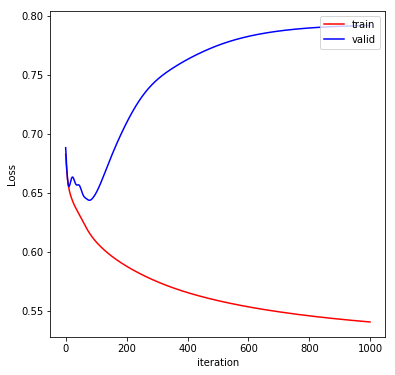

In [28]:
# Plot training and valid loss
t = np.arange(true_iteration - 1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t, np.array(valid_loss), 'b-')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper right')
plt.savefig("../img/loss_before_ensemble.png")
plt.show()

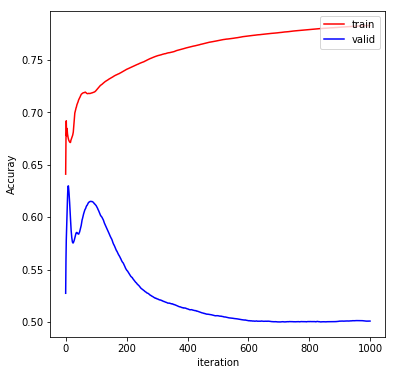

In [29]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t, valid_acc, 'b-')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'valid'], loc='upper right')
plt.savefig("../img/acc_before_ensemble.png")
plt.show()

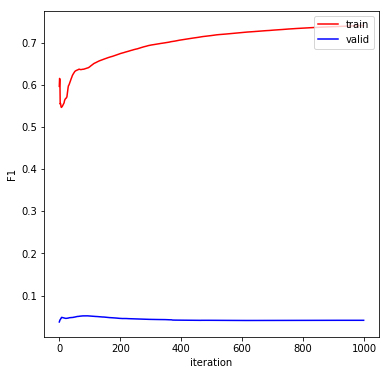

In [30]:
# Plot F1
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_f1), 'r-', t, valid_f1, 'b-')
plt.xlabel("iteration")
plt.ylabel("F1")
plt.legend(['train', 'valid'], loc='upper right')
plt.savefig("../img/f1_before_ensemble.png")
plt.show()

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
            
    true_iteration = 1
    for i in range(max_iterations):
        feed = {xs : X_train_oversampled, ys : y_train_oversampled, keep_prob : kp, learning_rate : lr}
        
        # train
        # print("++++++++++++++++++ train ++++++++++++++++++")
        loss, _ = sess.run([cost, train_op],feed_dict=feed)
        precision, recall, f1_score, accuracy = evaluate(X_train_oversampled, y_train_oversampled, sess)
        
        train_loss.append(loss)
        train_f1.append(f1_score)
        train_acc.append(accuracy)
        
        # valid cost
        loss_v = sess.run(cost, feed_dict={xs: X_valid, ys: y_valid, keep_prob: 1})
        valid_loss.append(loss_v)
        # valid evaluationX_testX_testX_testX_test
        # print("++++++++++++++++++ valid ++++++++++++++++++")
        valid_precision, valid_recall, valid_f1_score, valid_accuracy = evaluate(X_valid, y_valid, sess)
        valid_f1.append(valid_f1_score)
        valid_acc.append(valid_accuracy)

        if valid_f1_score >= 0.98:
            break
        print("Iteration: {}/{}\n".format(true_iteration, max_iterations),
              "Train loss: {:6f}".format(loss),
              "Train acc: {:.6f}".format(accuracy),
              "Train f1: {:.6f}\n".format(f1_score),
              "Valid loss: {:6f}".format(loss_v),
              "Valid acc: {:.6f}".format(valid_accuracy),
              "Valid f1: {:.6f}".format(valid_f1_score))
        true_iteration += 1
            
#     save_path = saver.save(sess,"mlp_2017/2017_save_net.ckpt")
#     print("Save to path:", save_path)
